## Seminario :: Analisi statistica spaziale di alcune proprietà dei suoli

### Laurea magistrale in scienze forestali ed ambientali
### Corso Siti Contaminati

Giuliano Langella<br>
[glangella@unina.it]

#### ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

### Step #2: Esempio applicativo, analisi spaziale nella "Terra dei Fuochi" [Cromo & Zinco]

#### ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

### Premessa

#### Ordinary kriging (OK)
The random field (RF) $\mathbf{Z}(\mathbf{u})$ is assumed to be intrinsic second‐order stationary if the first two moments (i.e. mean $\mathit{m}$ and semivariance $\gamma(\mathbf{h})$) of the two‐point RF increments exist and are invariant under translation and rotation within a bounded area $\mathfrak{D}$ (Goovaerts1997_book, Wackernagel2003_book):

\begin{eqnarray}
m &=& E \{ Z(\mathbf{u}) \} \nonumber\\
\gamma(\mathbf{h}) &=& \frac{1}{2}E\left\lbrace\left[ Z\left( \mathbf{u} \right) - Z\left( \mathbf{u}+\mathbf{h} \right) \right]^2 \right\rbrace
\end{eqnarray}

with theoretically infinite points locations ${u}(\mathbf{x})\in\mathfrak{D}$, and random variables (RV) $Z(\mathbf{u})$ and $Z(\mathbf{u}+\mathbf{h})$ separated by the distance vector $h(\mathbf{x})$, where $\textbf{x}$ represents the coordinates $(\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3)\in\Re^3$.

### Inquadramento

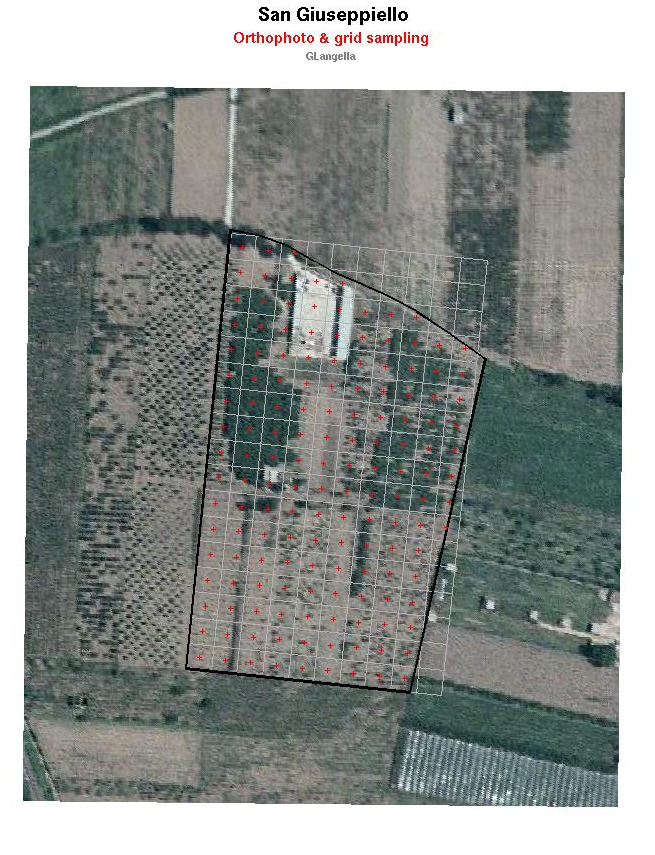

### D E F s

In [1]:
# gdalwarp -tr 3000 3000 work/People/Michela/andosols_spatstat/dem_20m_ispra/dtm_20m_32.tif ~/git/seminars/GeogrValutSuolo/dtm_3km_32.tif
printf <- function(...) cat(sprintf(...))

In [34]:
# Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

##### Requirements:

In [ ]:
#_________________
#
# P A C K A G E S
#_________________
require("ggplot2")
require("gridExtra")
require("dismo")
library("gstat")
require("rgdal")
library("sp")
library("raster")
library("geoR")

##### Import data (San Giuseppiello Proj):

In [27]:
# R E A D 
# xrf measurements
chrome 		<- read.table("~/git/seminars/Siti_Contaminati/Chrome-xrf.txt",header = TRUE, sep = ",",row.names=1,na.strings = "NaN")
zinc 		<- read.table("~/git/seminars/Siti_Contaminati/Zinc-xrf.txt",header = TRUE, sep = ",",row.names=1,na.strings = "NaN")
# grid for interpolations
grd 		<- read.table("~/git/seminars/Siti_Contaminati/xrf_grid.txt",header = TRUE, sep = ",")

##### Geospatial location of soil pits (Biosoil Proj):

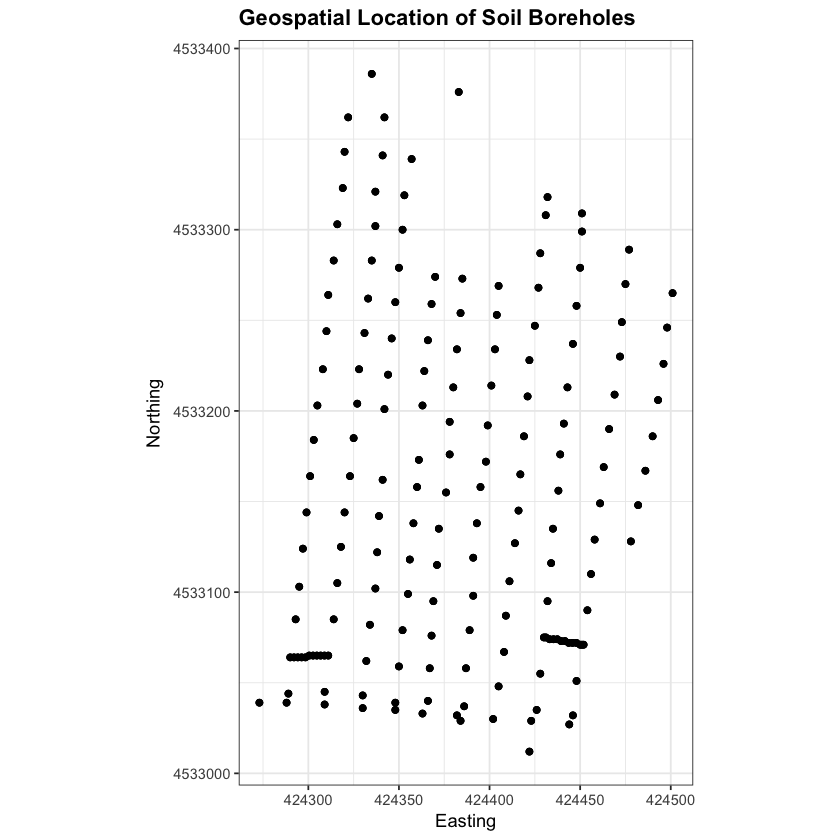

In [6]:
# see
#  http://stackoverflow.com/questions/41787313/how-to-create-a-grid-of-spatial-points
#  https://pakillo.github.io/R-GIS-tutorial/
it <- getData('GADM', country = 'IT', level = 1)
campania <- it[it$NAME_1 == "Campania",]
qplot(Easting, Northing, data=zinc) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("Geospatial Location of Soil Boreholes") + theme(plot.title = element_text(lineheight=.8, face="bold"))

##### Analisi statistica preliminare:

In [28]:
names(chrome)
names(zinc)

[1] "Easting"    "Northing"   "Layer"      "chrome"     "chromethre"
[6] "std"

[1] "Easting"  "Northing" "Layer"    "zinc"     "zincthre" "std"

In [29]:
summary(chrome[,c(4)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   37.0   138.0   333.0   468.7   583.5  3452.0 

In [30]:
summary(zinc[,c(4)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   62.0   147.0   245.5   307.5   371.5  1490.0 

In [33]:
#cor( D[,17],D[,c(1,11:16)] ) # , na.rm = TRUE
cor( chrome$chrome,zinc$zinc ) # , na.rm = TRUE

[1] 0.8994706

#### Istogramma delle concentrazioni in funzione delle profondità

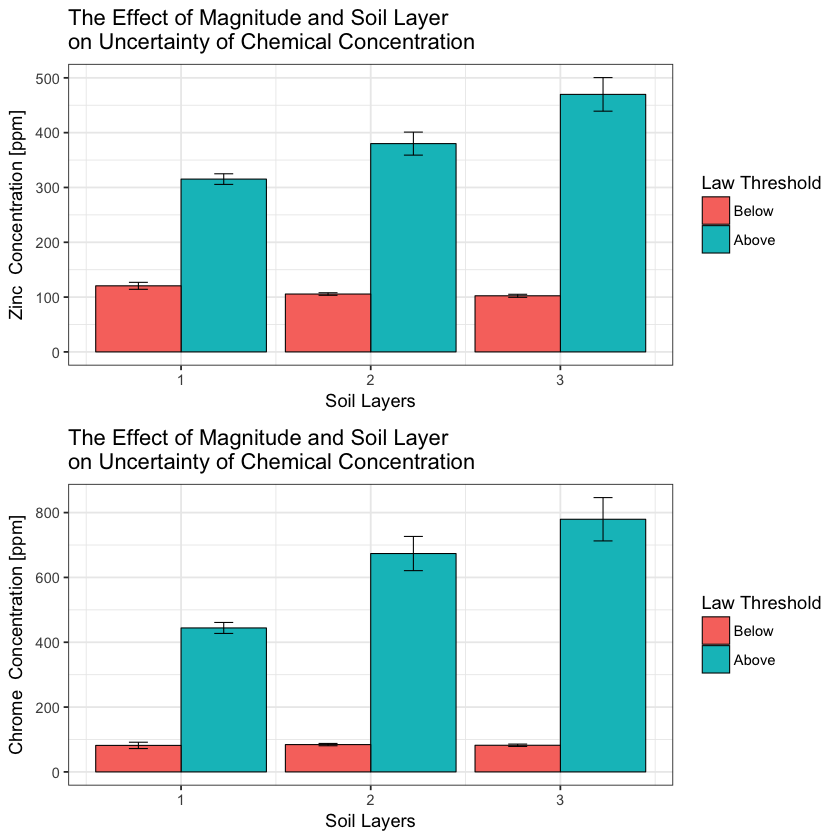

In [42]:
# S Y N T H E S I S
tgc_Z <- summarySE( zinc,measurevar="zinc",groupvars=c("Layer","zincthre") )
tgc_C <- summarySE( chrome,measurevar="chrome",groupvars=c("Layer","chromethre") )
# bar :: aggregating previous response
plt1 <- ggplot(tgc_Z, aes(x=Layer, y=zinc, fill=factor(zincthre))) + 
    geom_bar(position=position_dodge(), stat="identity",
             colour="black", # Use black outlines,
             size=.3) +      # Thinner lines
    geom_errorbar(aes(ymin=zinc-se, ymax=zinc+se),
                  size=.3,    # Thinner lines
                  width=.2,
                  position=position_dodge(.9)) +
    xlab("Soil Layers") +
    ylab( paste("Zinc ","Concentration [ppm]")) +
    scale_fill_hue(name="Law Threshold", # Legend label, use darker colors
                   breaks=c(0, 1),
                   labels=c("Below", "Above")) +
    ggtitle("The Effect of Magnitude and Soil Layer\non Uncertainty of Chemical Concentration") +
    #scale_y_continuous(breaks=0:20*4) +
    theme_bw()
plt2 <- ggplot(tgc_C, aes(x=Layer, y=chrome, fill=factor(chromethre))) + 
    geom_bar(position=position_dodge(), stat="identity",
             colour="black", # Use black outlines,
             size=.3) +      # Thinner lines
    geom_errorbar(aes(ymin=chrome-se, ymax=chrome+se),
                  size=.3,    # Thinner lines
                  width=.2,
                  position=position_dodge(.9)) +
    xlab("Soil Layers") +
    ylab( paste("Chrome ","Concentration [ppm]")) +
    scale_fill_hue(name="Law Threshold", # Legend label, use darker colors
                   breaks=c(0, 1),
                   labels=c("Below", "Above")) +
    ggtitle("The Effect of Magnitude and Soil Layer\non Uncertainty of Chemical Concentration") +
    #scale_y_continuous(breaks=0:20*4) +
    theme_bw()
grid.arrange(plt1,plt2,ncol=1,nrow=2)

#### Zinc levels in soils at different depths:

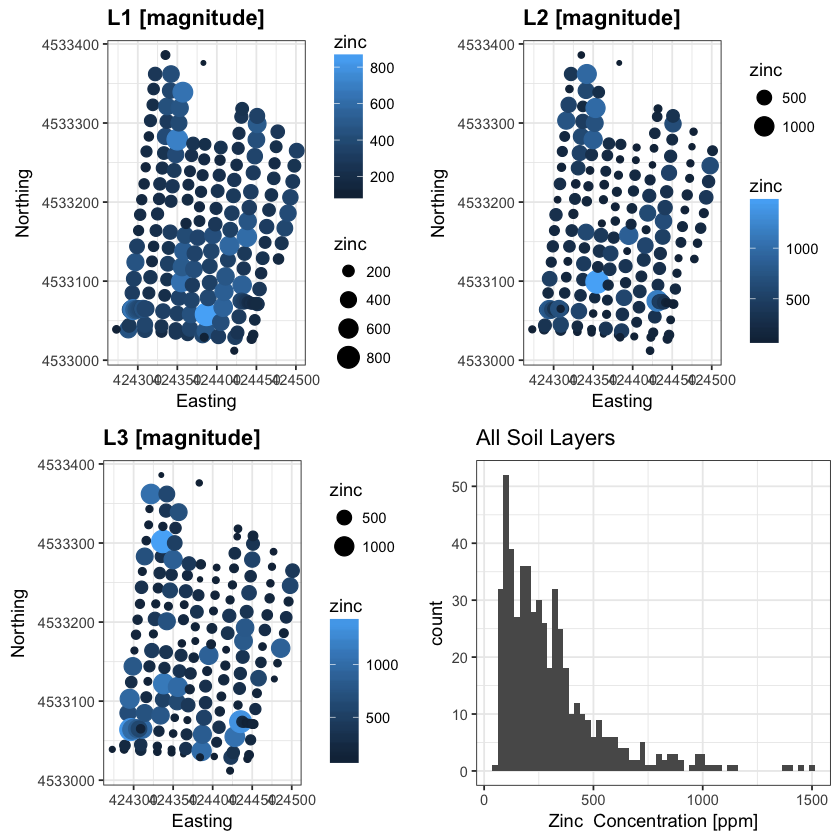

In [43]:
plt1 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==1),], colour=zinc, size=zinc) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L1 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==2),], colour=zinc, size=zinc) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L2 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==3),], colour=zinc, size=zinc) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L3 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt4 <- qplot(zinc, data=zinc, geom="histogram",binwidth=25,main="All Soil Layers") + theme_bw() + xlab( paste("Zinc ","Concentration [ppm]") )
grid.arrange(plt1,plt2,plt3,plt4,ncol=2,nrow=2)

#### Chrome levels in soils at different depths:

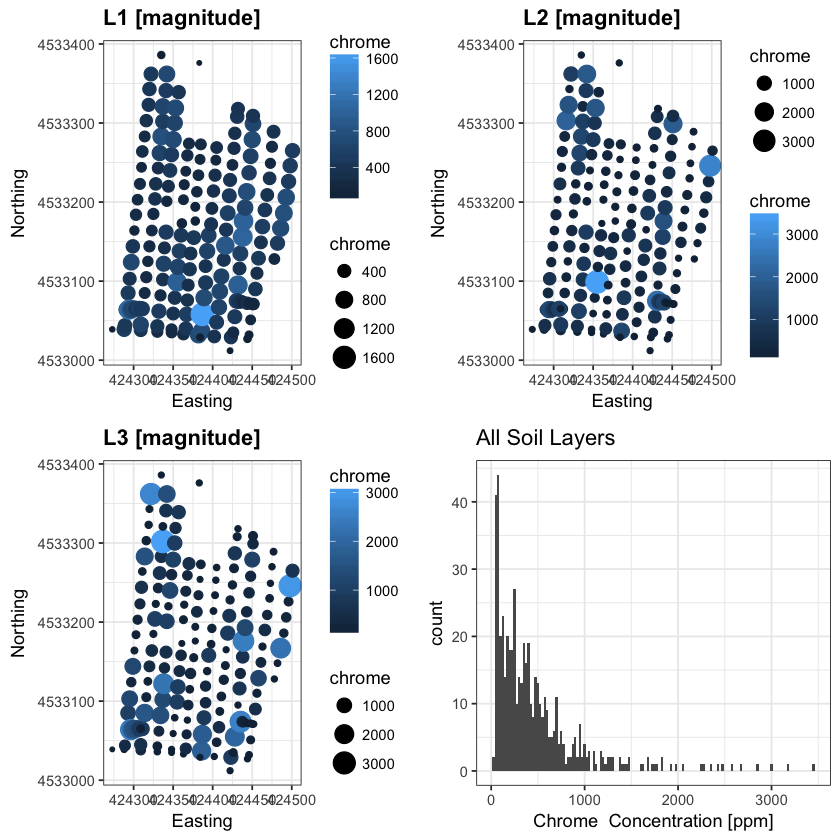

In [44]:
plt1 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==1),], colour=chrome, size=chrome) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L1 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==2),], colour=chrome, size=chrome) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L2 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==3),], colour=chrome, size=chrome) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L3 [magnitude]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt4 <- qplot(chrome, data=chrome, geom="histogram",binwidth=25,main="All Soil Layers") + theme_bw() + xlab( paste("Chrome ","Concentration [ppm]") )
grid.arrange(plt1,plt2,plt3,plt4,ncol=2,nrow=2)

#### Superamento limiti di legge

##### Zinc

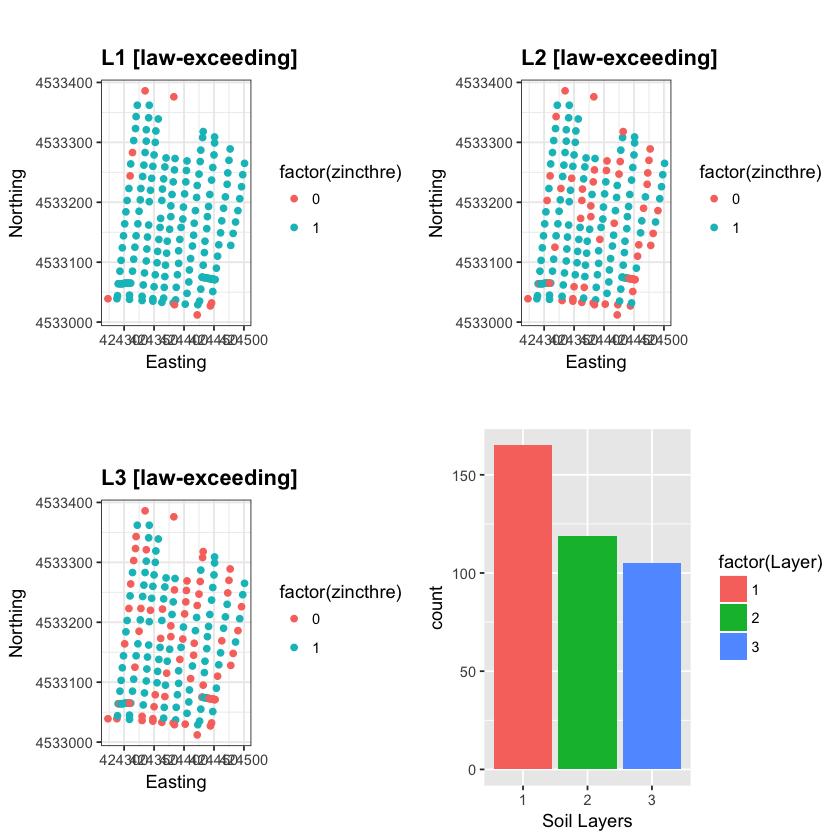

In [45]:
plt1 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==1),], colour=factor(zincthre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L1 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==2),], colour=factor(zincthre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L2 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- qplot(Easting, Northing, data=zinc[which(zinc$Layer==3),], colour=factor(zincthre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L3 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt4 <- qplot(factor(Layer),data=zinc[which(zinc$zincthre==1),],geom="bar",fill=factor(Layer)) + xlab("Soil Layers")
grid.arrange(plt1,plt2,plt3,plt4,ncol=2,nrow=2)

##### Chrome

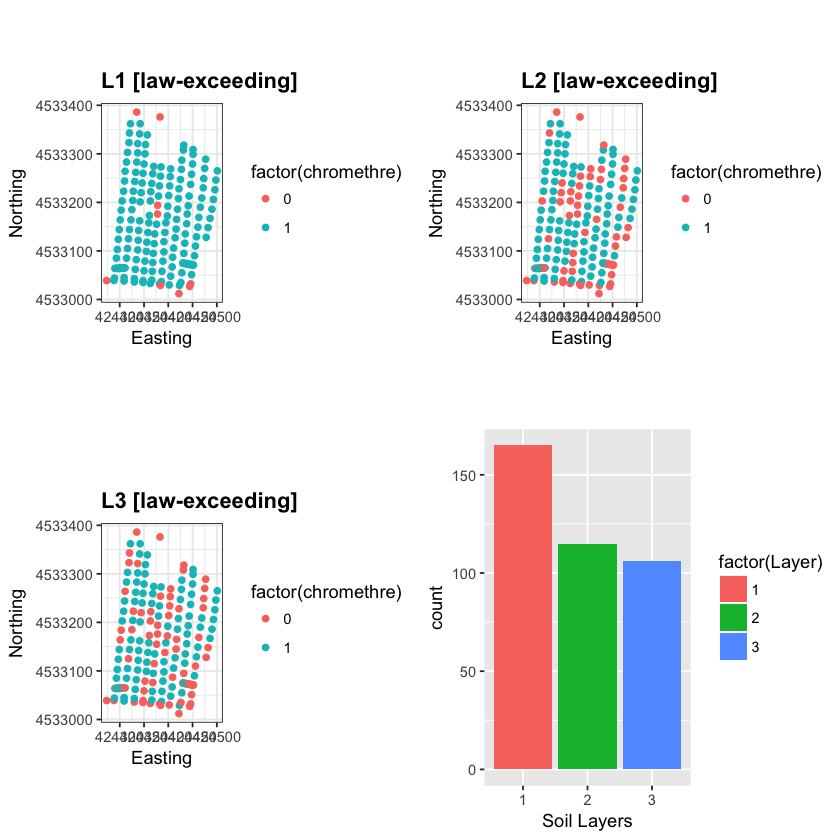

In [46]:
plt1 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==1),], colour=factor(chromethre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L1 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==2),], colour=factor(chromethre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L2 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- qplot(Easting, Northing, data=chrome[which(chrome$Layer==3),], colour=factor(chromethre)) + coord_fixed(ratio = 1) + theme_bw() + ggtitle("L3 [law-exceeding]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt4 <- qplot(factor(Layer),data=chrome[which(chrome$chromethre==1),],geom="bar",fill=factor(Layer)) + xlab("Soil Layers")
grid.arrange(plt1,plt2,plt3,plt4,ncol=2,nrow=2)

#### Incertezza di misura al variare del livello di concentrazione del contaminante

##### Zinc

In [ ]:
ggplot(zinc, aes(x=1:length(zinc$zinc), y=zinc, colour=factor(zincthre))) + 
    geom_errorbar(aes(ymin=zinc-std, ymax=zinc+std), width=.01) +
    xlab("Samples") +
    ylab( paste("Zinc ","Concentration [ppm]") ) +
    scale_colour_hue(name="Law Threshold",    	# Legend label, use darker colors
                     breaks=c(0, 1),
                     labels=c("Below", "Above"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("The Effect of Magnitude \n on Chemical Concentration Uncertainty") +
    expand_limits(y=0) +                        # Expand y range
    #scale_y_continuous(breaks=0:20*4) +        # Set tick every 4
    theme_bw() +
    theme(legend.justification=c(1,0)
          #,legend.position=c(.5,.8)             # Position legend in bottom right
          )

##### Chrome

In [ ]:
ggplot(chrome, aes(x=1:length(chrome$chrome), y=chrome, colour=factor(chromethre))) + 
    geom_errorbar(aes(ymin=chrome-std, ymax=chrome+std), width=.01) +
    xlab("Samples") +
    ylab( paste("Chrome ","Concentration [ppm]") ) +
    scale_colour_hue(name="Law Threshold",    	# Legend label, use darker colors
                     breaks=c(0, 1),
                     labels=c("Below", "Above"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("The Effect of Magnitude \n on Chemical Concentration Uncertainty") +
    expand_limits(y=0) +                        # Expand y range
    #scale_y_continuous(breaks=0:20*4) +        # Set tick every 4
    theme_bw() +
    theme(legend.justification=c(1,0)
          #,legend.position=c(.5,.8)             # Position legend in bottom right
          )

### Grids

#### Configurazione del contesto geospaziale:

In [57]:
#___________
#
# G R I D S
#___________

# data
coordinates(zinc)   = ~Easting+Northing
coordinates(chrome) = ~Easting+Northing
# grid
coordinates(grd) = ~Easting+Northing
gridded(grd) = TRUE

#### Sommario del contesto geospaziale:

In [59]:
#summary(zinc)
#summary(chrome)

### CHROME

#### Variography | omnidirectional | raw

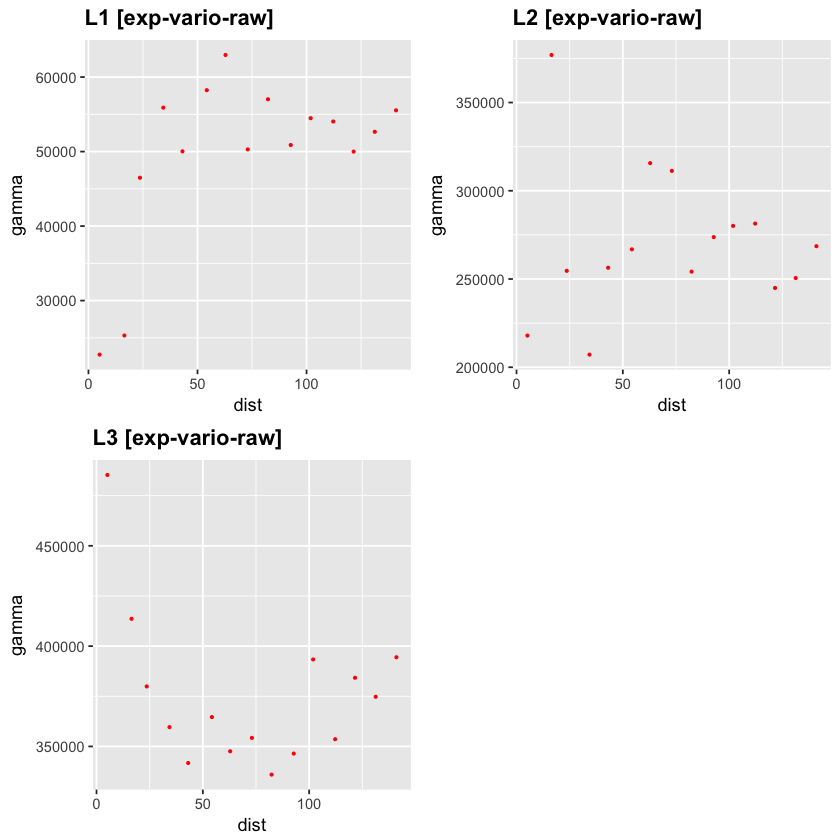

In [60]:
vgm.exp.n.L1 	= variogram( chrome~1, chrome[which(chrome$Layer==1),])
vgm.exp.n.L2 	= variogram( chrome~1, chrome[which(chrome$Layer==2),])
vgm.exp.n.L3 	= variogram( chrome~1, chrome[which(chrome$Layer==3),])
plt1 <- ggplot(data=vgm.exp.n.L1,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L1 [exp-vario-raw]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- ggplot(data=vgm.exp.n.L2,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L2 [exp-vario-raw]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- ggplot(data=vgm.exp.n.L3,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L3 [exp-vario-raw]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

#### Variography | omnidirectional | log

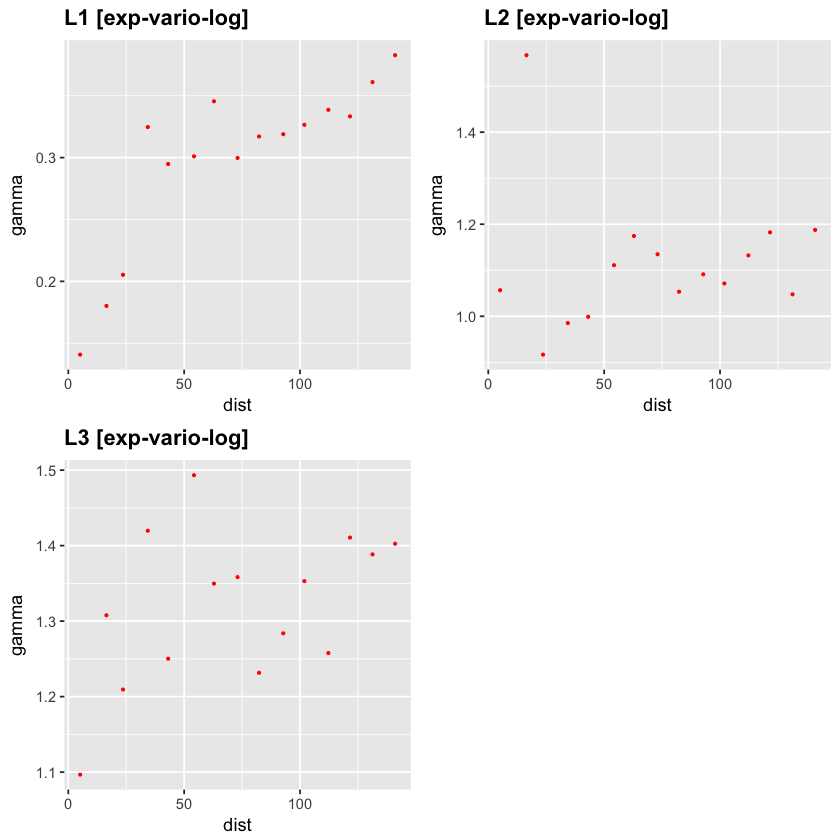

In [61]:
vgm.exp.log.L1 = variogram( log(chrome)~1, chrome[which(chrome$Layer==1),])
vgm.exp.log.L2 = variogram( log(chrome)~1, chrome[which(chrome$Layer==2),])
vgm.exp.log.L3 = variogram( log(chrome)~1, chrome[which(chrome$Layer==3),])
plt1 <- ggplot(data=vgm.exp.log.L1,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L1 [exp-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- ggplot(data=vgm.exp.log.L2,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L2 [exp-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- ggplot(data=vgm.exp.log.L3,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.5) + ggtitle("L3 [exp-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

#### Variography | omnidirectional | log & cloud

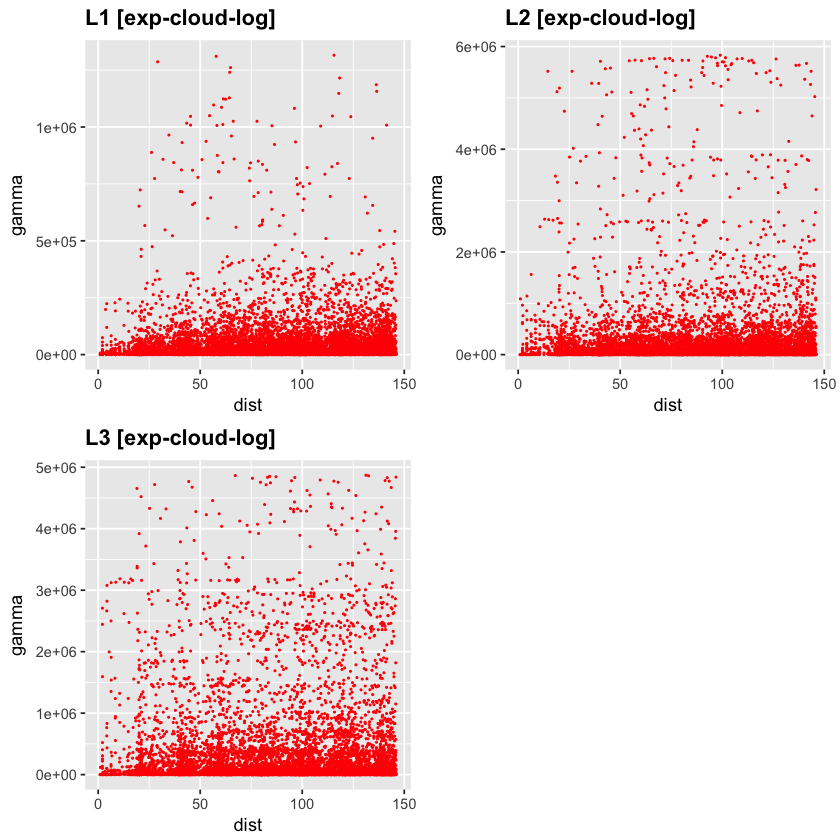

In [62]:
vgm.exp.log.L1c 	= variogram( chrome~1, chrome[which(chrome$Layer==1),], cloud=TRUE)
vgm.exp.log.L2c 	= variogram( chrome~1, chrome[which(chrome$Layer==2),], cloud=TRUE)
vgm.exp.log.L3c 	= variogram( chrome~1, chrome[which(chrome$Layer==3),], cloud=TRUE)
plt1 <- ggplot(data=vgm.exp.log.L1c,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.2) + ggtitle("L1 [exp-cloud-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt2 <- ggplot(data=vgm.exp.log.L2c,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.2) + ggtitle("L2 [exp-cloud-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
plt3 <- ggplot(data=vgm.exp.log.L3c,aes(x=dist,y=gamma)) + geom_point(color='red',size=0.2) + ggtitle("L3 [exp-cloud-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

Warning message in fit.variogram(vgm.exp.log.L2, model = vgm(1, "Exp", 100, 0.1), :
“No convergence after 200 iterations: try different initial values?”

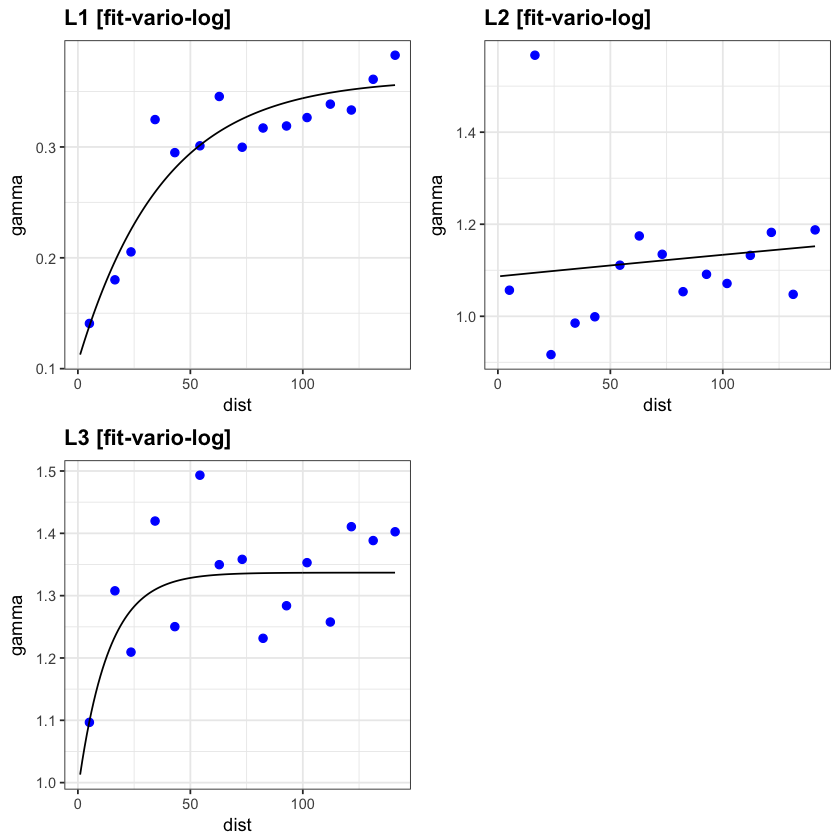

In [63]:
#   -fitting	vgm(psill, model, range, nugget, ...)
vgm.fit.log.L1 = fit.variogram( vgm.exp.log.L1, model=vgm(0.30,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
vgm.fit.log.L2 = fit.variogram( vgm.exp.log.L2, model=vgm(1.00,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
vgm.fit.log.L3 = fit.variogram( vgm.exp.log.L3, model=vgm(1.00,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )

# L1
maxDist <- round(max(vgm.exp.log.L1$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L1$psill[1] + vgm.fit.log.L1$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L1$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt1 <- ggplot(data=vgm.exp.log.L1,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma),color='black') + theme_bw() + 
				ggtitle("L1 [fit-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L2
maxDist <- round(max(vgm.exp.log.L2$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L2$psill[1] + vgm.fit.log.L2$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L2$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt2 <- ggplot(data=vgm.exp.log.L2,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle("L2 [fit-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L3
maxDist <- round(max(vgm.exp.log.L3$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L3$psill[1] + vgm.fit.log.L3$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L3$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt3 <- ggplot(data=vgm.exp.log.L3,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle("L3 [fit-vario-log]") + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

#### Rimozione delle coppie di punti caratterizzati da alta covarianza a corta distanza:

In [66]:
# remove couples with high covariance but short distance apart:
#   <L1>
chrome_L1 			<- data.frame(	chrome[which(chrome$Layer==1),] )
coordinates(chrome_L1) = ~Easting+Northing
vgm.exp.log.L1c_rd = variogram( chrome~1, chrome_L1, cloud=TRUE)
short_dist 	<- vgm.exp.log.L1c[which(vgm.exp.log.L1c_rd$dist<5.0),]
high_gamma 	<- short_dist[which(short_dist$gamma>100000),]
high_gamma 	<- data.frame(high_gamma)
list_remove <- sort(unique( c(high_gamma$left,high_gamma$right) ))
rem.L1 <- length(list_remove)
if(length(list_remove)==0){
	chrome_L1_rd   <- chrome_L1
}else{
	chrome_L1_rd   <- chrome_L1[-list_remove,]
}

#   <L2>
chrome_L2 			<- data.frame(	chrome[which(chrome$Layer==2),] )
coordinates(chrome_L2) = ~Easting+Northing
vgm.exp.log.L2c_rd = variogram( chrome~1, chrome_L2, cloud=TRUE)
short_dist 	<- vgm.exp.log.L2c[which(vgm.exp.log.L2c_rd$dist<5.0),]
high_gamma 	<- short_dist[which(short_dist$gamma>100000),]
high_gamma 	<- data.frame(high_gamma)
list_remove <- sort(unique( c(high_gamma$left,high_gamma$right) ))
rem.L2 <- length(list_remove)
if(length(list_remove)==0){
	chrome_L2_rd   <- chrome_L2
}else{
	chrome_L2_rd   <- chrome_L2[-list_remove,]
}

#   <L3>
chrome_L3 			<- data.frame(	chrome[which(chrome$Layer==3),] )
coordinates(chrome_L3) = ~Easting+Northing
vgm.exp.log.L3c_rd = variogram( chrome~1, chrome_L3, cloud=TRUE)
short_dist 	<- vgm.exp.log.L3c[which(vgm.exp.log.L3c_rd$dist<5.0),]
high_gamma 	<- short_dist[which(short_dist$gamma>100000),]
high_gamma 	<- data.frame(high_gamma)
list_remove <- sort(unique( c(high_gamma$left,high_gamma$right) ))
chrome_L3_rd   <- chrome_L3[-list_remove,]
rem.L3 <- length(list_remove)
if(length(list_remove)==0){
	chrome_L3_rd   <- chrome_L3
}else{
	chrome_L3_rd   <- chrome_L3[-list_remove,]
}

#### REMOVED [fit-vario-raw]:

Warning message in fit.variogram(vgm.exp.raw.L1_rd, model = vgm(psill, "Exp", range, :
“partial sill or nugget fixed at zero value”Warning message in fit.variogram(vgm.exp.raw.L2_rd, model = vgm(psill, "Exp", range, :
“singular model in variogram fit”Warning message in fit.variogram(vgm.exp.raw.L3_rd, model = vgm(psill, "Exp", range, :
“No convergence after 200 iterations: try different initial values?”Warning message in fit.variogram(vgm.exp.raw.L3_rd, model = vgm(psill, "Exp", range, :
“partial sill or nugget fixed at zero value”Warning message in fit.variogram(object, model, fit.sills = fit.sills, fit.ranges = fit.ranges, :
“singular model in variogram fit”

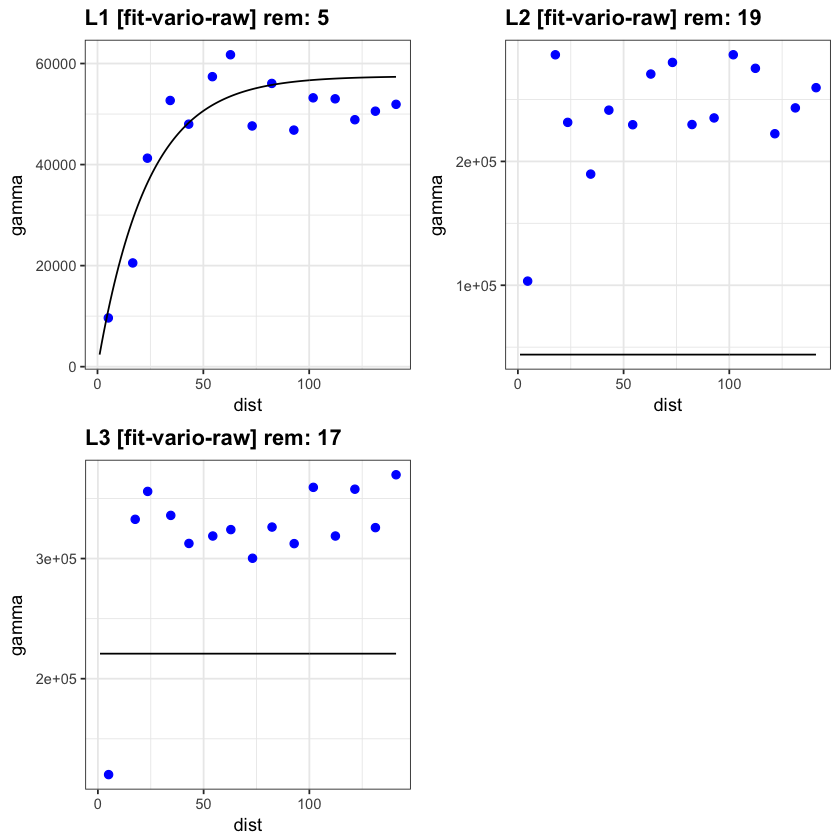

In [67]:
#coordinates(xrf_L1_rd) = ~Easting+Northing
vgm.exp.raw.L1_rd = variogram( chrome~1, chrome_L1_rd)# vgm( psill, model, range, nugget )
psill 	= max(vgm.exp.raw.L1_rd$gamma) - min(vgm.exp.raw.L1_rd$gamma)
range 	= max(vgm.exp.raw.L1_rd$dist)/6
nugget 	= vgm.exp.raw.L1_rd$gamma[1]/2
vgm.fit.raw.L1_rd = fit.variogram( vgm.exp.raw.L1_rd, model=vgm(psill,'Exp',range,nugget), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#coordinates(xrf_L2_rd) = ~Easting+Northing
vgm.exp.raw.L2_rd = variogram( chrome~1, chrome_L2_rd)
psill 	= max(vgm.exp.raw.L2_rd$gamma) - min(vgm.exp.raw.L2_rd$gamma)
range 	= max(vgm.exp.raw.L2_rd$dist)/6
nugget 	= vgm.exp.raw.L2_rd$gamma[1]/2
vgm.fit.raw.L2_rd = fit.variogram( vgm.exp.raw.L2_rd, model=vgm(psill,'Exp',range,nugget), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#coordinates(xrf_L3_rd) = ~Easting+Northing
vgm.exp.raw.L3_rd = variogram( chrome~1, chrome_L3_rd)
psill 	= max(vgm.exp.raw.L3_rd$gamma) - min(vgm.exp.raw.L3_rd$gamma)
range 	= max(vgm.exp.raw.L3_rd$dist)/6
nugget 	= vgm.exp.raw.L3_rd$gamma[1]
vgm.fit.raw.L3_rd = fit.variogram( vgm.exp.raw.L3_rd, model=vgm(psill,'Exp',range,nugget), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#plot(vgm.exp_log,vgm.fit_log, main = paste("[OMNI-DIR] Fitted Variogram",ChElstr,"[raw data]"))
# L1
maxDist <- round(max(vgm.exp.raw.L1_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.raw.L1_rd$psill[1] + vgm.fit.raw.L1_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.raw.L1_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt1 <- ggplot(data=vgm.exp.raw.L1_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma),color='black') + theme_bw() + 
				ggtitle(paste("L1 [fit-vario-raw] rem:",rem.L1)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L2
maxDist <- round(max(vgm.exp.raw.L2_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.raw.L2_rd$psill[1] + vgm.fit.raw.L2_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.raw.L2_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt2 <- ggplot(data=vgm.exp.raw.L2_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle(paste("L2 [fit-vario-raw] rem:",rem.L2)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L3
maxDist <- round(max(vgm.exp.raw.L3_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.raw.L3_rd$psill[1] + vgm.fit.raw.L3_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.raw.L3_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt3 <- ggplot(data=vgm.exp.raw.L3_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle(paste("L3 [fit-vario-raw] rem:",rem.L3)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

#### REMOVED [fit-vario-log]:

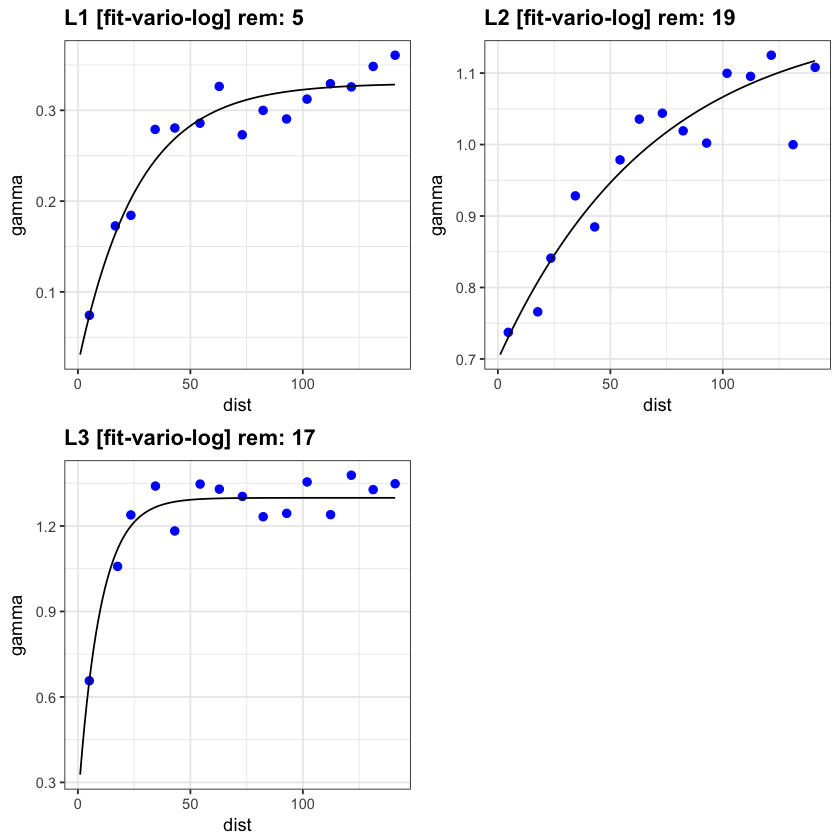

In [68]:
#coordinates(xrf_L1_rd) = ~Easting+Northing
vgm.exp.log.L1_rd = variogram( log(chrome)~1, chrome_L1_rd)
vgm.fit.log.L1_rd = fit.variogram( vgm.exp.log.L1_rd, model=vgm(0.90,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#coordinates(xrf_L2_rd) = ~Easting+Northing
vgm.exp.log.L2_rd = variogram( log(chrome)~1, chrome_L2_rd)
vgm.fit.log.L2_rd = fit.variogram( vgm.exp.log.L2_rd, model=vgm(0.90,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#coordinates(xrf_L3_rd) = ~Easting+Northing
vgm.exp.log.L3_rd = variogram( log(chrome)~1, chrome_L3_rd)
vgm.fit.log.L3_rd = fit.variogram( vgm.exp.log.L3_rd, model=vgm(0.90,'Exp',100,0.1), fit.sills = TRUE, fit.ranges = TRUE, fit.method = 7, debug.level = 1, warn.if.neg = TRUE )
#plot(vgm.exp_log,vgm.fit_log, main = paste("[OMNI-DIR] Fitted Variogram",ChElstr,"[log data]"))
# L1
maxDist <- round(max(vgm.exp.log.L1_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L1_rd$psill[1] + vgm.fit.log.L1_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L1_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt1 <- ggplot(data=vgm.exp.log.L1_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma),color='black') + theme_bw() + 
				ggtitle(paste("L1 [fit-vario-log] rem:",rem.L1)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L2
maxDist <- round(max(vgm.exp.log.L2_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L2_rd$psill[1] + vgm.fit.log.L2_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L2_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt2 <- ggplot(data=vgm.exp.log.L2_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle(paste("L2 [fit-vario-log] rem:",rem.L2)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
# L3
maxDist <- round(max(vgm.exp.log.L3_rd$dist))
vgm.fit.plot <- data.frame(1:maxDist,g_exp <- vgm.fit.log.L3_rd$psill[1] + vgm.fit.log.L3_rd$psill[2]*( 1 - exp(-(1:maxDist/vgm.fit.log.L3_rd$range[2])) ) )
names(vgm.fit.plot) <- c("dist","gamma")
plt3 <- ggplot(data=vgm.exp.log.L3_rd,aes(x=dist,y=gamma)) + geom_point(color='blue',size=2) + geom_line(data=vgm.fit.plot, aes(x=dist,y=gamma)) + theme_bw() + 
				ggtitle(paste("L3 [fit-vario-log] rem:",rem.L3)) + theme(plot.title = element_text(lineheight=.8, face="bold"))
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

### Predictions

In [84]:
#printf( "Reference system: %s\n",proj4string(grd) )
#printf( "Pixel size [%fm, %fm]\n", res(grd)[1],res(grd)[2] ) # x-y pixel size
#plot(grd)#,add=T) # add monitoring points

##### Assign projection to point data

In [ ]:
#proj4string(zinc)   <- CRS(proj4string(grd))
#proj4string(chrome) <- CRS(proj4string(grd))

##### Ordinary Kriging

R A W

In [ ]:
# ...

L O G

[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]


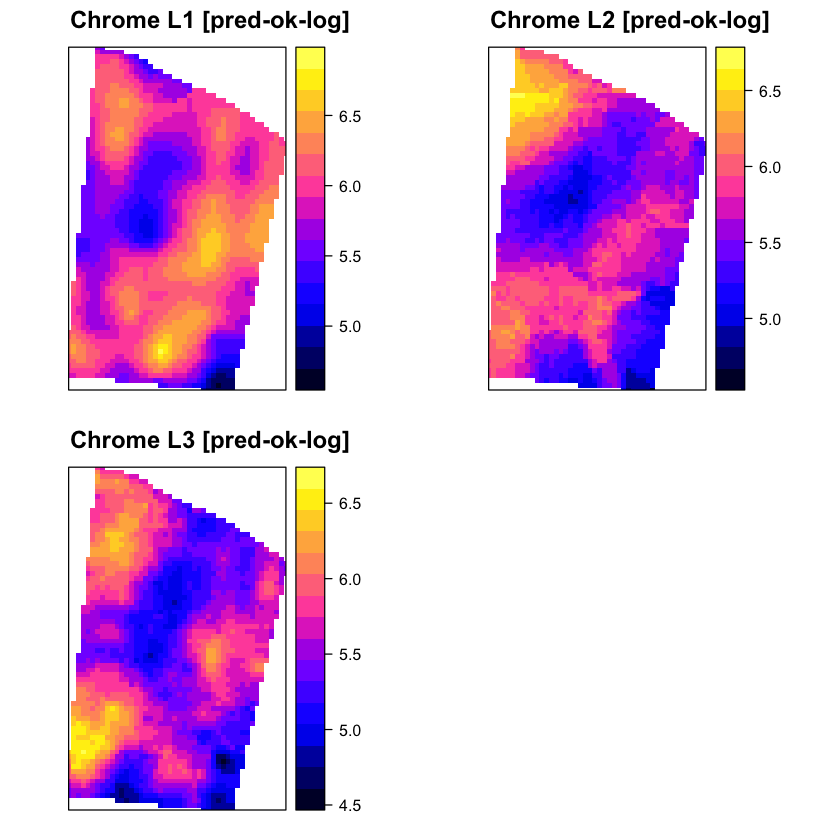

In [85]:
#   -local
krg.ok.log.L1 = krige(log(chrome)~1, chrome[which(chrome$Layer==1),], grd, model = vgm.fit.log.L1, nmax=20, nmin=5, maxdist=60)
krg.ok.log.L2 = krige(log(chrome)~1, chrome[which(chrome$Layer==2),], grd, model = vgm.fit.log.L2, nmax=20, nmin=5, maxdist=60)
krg.ok.log.L3 = krige(log(chrome)~1, chrome[which(chrome$Layer==3),], grd, model = vgm.fit.log.L3, nmax=20, nmin=5, maxdist=60)
plt1 = spplot(krg.ok.log.L1, "var1.pred", main="Chrome L1 [pred-ok-log]")
plt2 = spplot(krg.ok.log.L2, "var1.pred", main="Chrome L2 [pred-ok-log]")
plt3 = spplot(krg.ok.log.L3, "var1.pred", main="Chrome L3 [pred-ok-log]")
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

R A W | After Removal

In [ ]:
# ...

L O G | After Removal

[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]


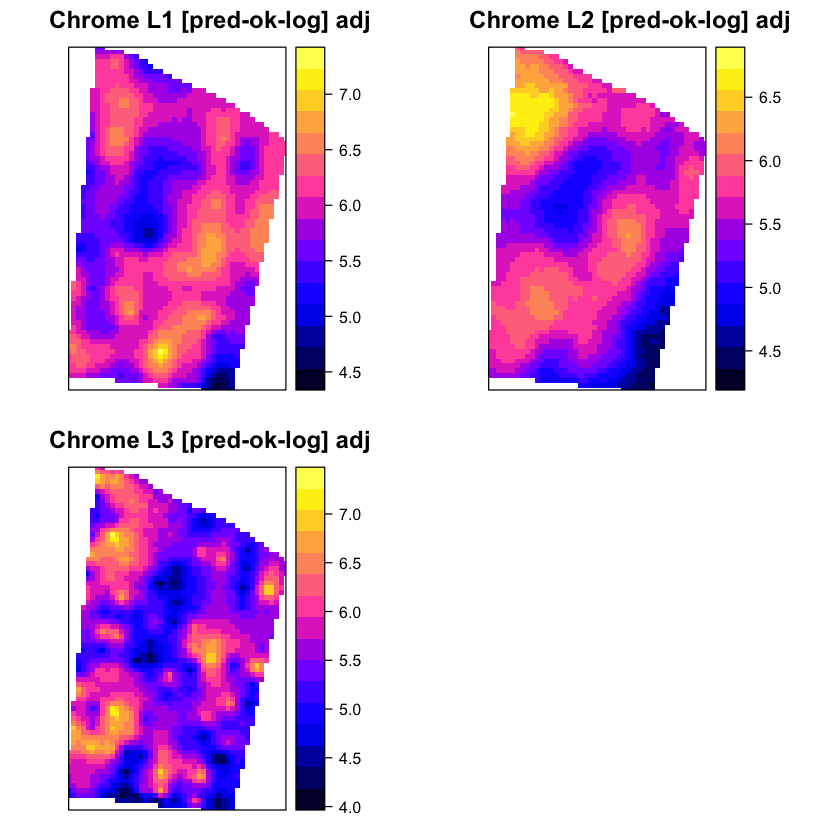

In [86]:
krg.ok.log.L1_rd = krige(log(chrome)~1, chrome_L1_rd, grd, model = vgm.fit.log.L1_rd, nmax=20, nmin=5, maxdist=60)
krg.ok.log.L2_rd = krige(log(chrome)~1, chrome_L2_rd, grd, model = vgm.fit.log.L2_rd, nmax=20, nmin=5, maxdist=60)
krg.ok.log.L3_rd = krige(log(chrome)~1, chrome_L3_rd, grd, model = vgm.fit.log.L3_rd, nmax=20, nmin=5, maxdist=60)
plt1 = spplot(krg.ok.log.L1_rd, "var1.pred", main="Chrome L1 [pred-ok-log] adj")
plt2 = spplot(krg.ok.log.L2_rd, "var1.pred", main="Chrome L2 [pred-ok-log] adj")
plt3 = spplot(krg.ok.log.L3_rd, "var1.pred", main="Chrome L3 [pred-ok-log] adj")
grid.arrange(plt1,plt2,plt3,ncol=2,nrow=2)

Sintesi:
<ul>
  <li> rimozione delle coppie di punti "outliers", </li>
  <li> fitting del variogramma sperimentale con un modello di variogramma ammissibile, </li>
  <ul>
    <li> sia sulla variabile (=Cromo) tal quale, </li>
    <li> sia sulla variabile (=Cromo) in scale logaritmica, </li>
  </ul>
  
  <li> interpolazione mediante kriging ordinario in entrambi i casi, </li>
  <li> le mappe ottenute "dopo rimozione delle coppie di punti", </li>
  <ul>
    <li> presentano un maggiore dettaglio spaziale, </li>
    <li> sono caratterizzare da minore rumore. </li>
  </ul>
</ul>

### Conditional Gaussian Simulations

drawing 10 GLS realisations of beta...
[using conditional Gaussian simulation]
drawing 10 GLS realisations of beta...
[using conditional Gaussian simulation]
drawing 10 GLS realisations of beta...
[using conditional Gaussian simulation]


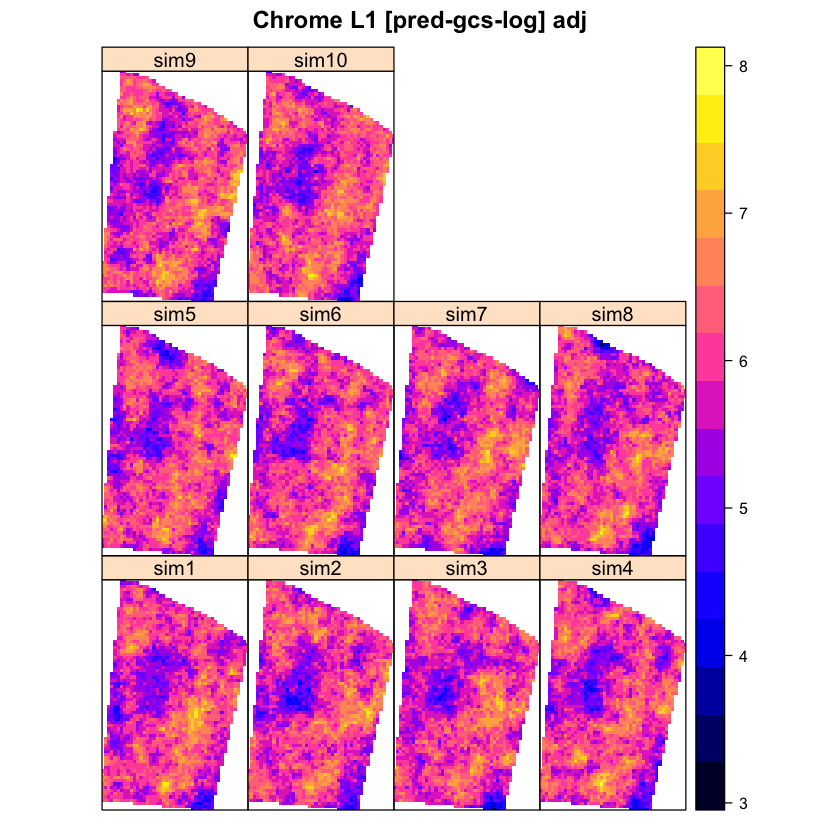

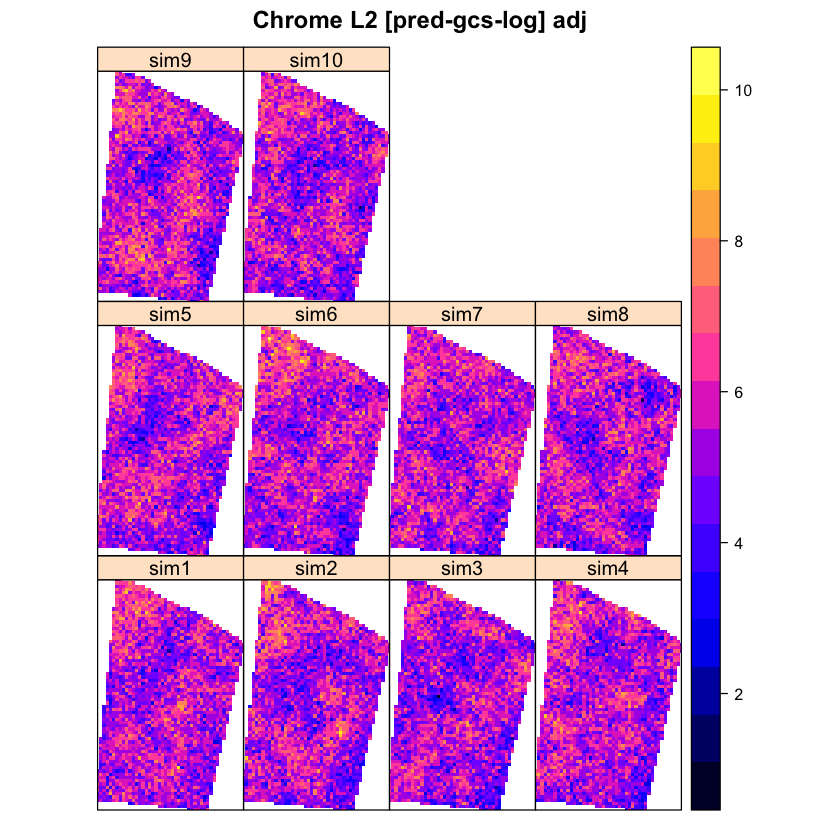

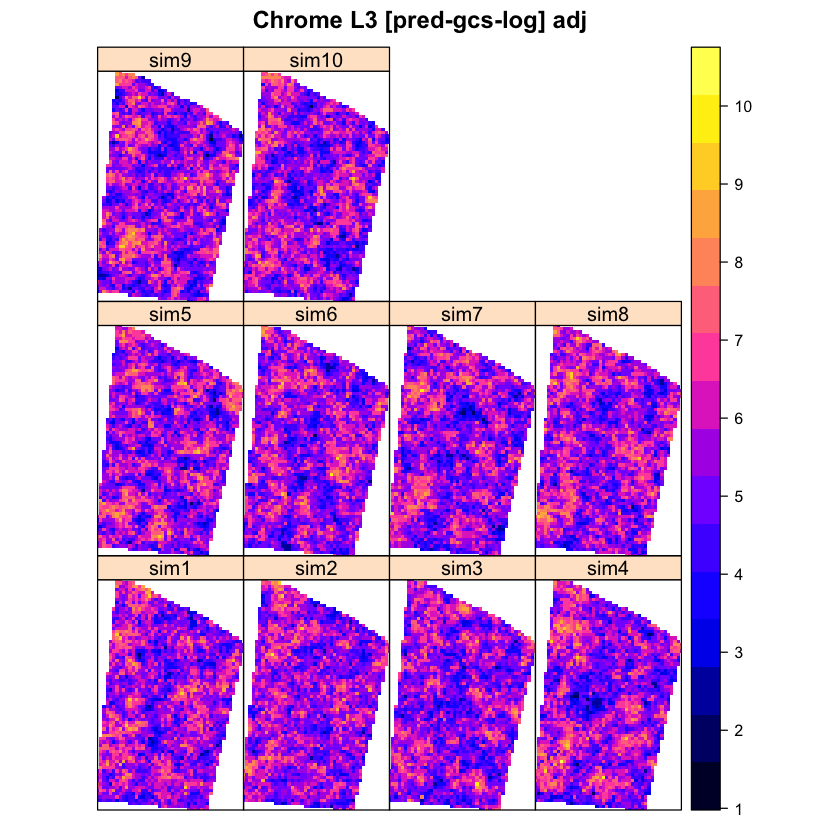

In [88]:
gcs_nsim = 10
krg.gcs.log.L1_rd = krige(log(chrome)~1, chrome_L1_rd, grd, model = vgm.fit.log.L1_rd, nmax=20, nmin=5, maxdist=60, nsim=gcs_nsim)
krg.gcs.log.L2_rd = krige(log(chrome)~1, chrome_L2_rd, grd, model = vgm.fit.log.L2_rd, nmax=20, nmin=5, maxdist=60, nsim=gcs_nsim)
krg.gcs.log.L3_rd = krige(log(chrome)~1, chrome_L3_rd, grd, model = vgm.fit.log.L3_rd, nmax=20, nmin=5, maxdist=60, nsim=gcs_nsim)
spplot(krg.gcs.log.L1_rd, main = "Chrome L1 [pred-gcs-log] adj" )
spplot(krg.gcs.log.L2_rd, main = "Chrome L2 [pred-gcs-log] adj" )
spplot(krg.gcs.log.L3_rd, main = "Chrome L3 [pred-gcs-log] adj" )

#### S A V E | Analysis of Uncertainty

In [90]:
# gcs | layer #1
gcs_nsim = 200
krg.gcs.raw.L1_rd = krige( chrome~1, chrome_L1_rd, grd, model = vgm.fit.raw.L1_rd, 
                           nmax=20, nmin=5, maxdist=60, nsim=gcs_nsim )
write.table( krg.gcs.raw.L1_rd, file="L1_gcs_raw.txt",sep=",",
             na="NaN",col.names=TRUE,row.names=FALSE )

drawing 200 GLS realisations of beta...
[using conditional Gaussian simulation]
